# ------------------------ Pipelines & PythonScript Tutorial ------------------------

**Author:** ClaemWu  
**Affiliation:** HKBU AEF MscDABE  

## Overview

This tutorial provides detailed examples to explain the concepts and working principles of data pipelines, as well as the usage of Python scripts. 

**Note:** This tutorial is intended for learning and reference purposes only and does not carry any academic credit or certification.

# Core Concept of Pipeline

**Pipeline** (also known as Data Pipeline) refers to a **systematic, automated workflow model** that orchestrates a sequence of data processing and analysis tasks. It structures code execution into a **directed graph of discrete, modular steps**, where:

- **Modular Steps:** Each step is an independent, self-contained unit of work (e.g., data extraction, cleaning, transformation, validation, model training, or result export).
- **Isolation & Encapsulation:** Steps operate in isolation, with clearly defined inputs and outputs. They do not share internal states or data directly, communicating only through specified interfaces or data channels.
- **Automated Flow:** The pipeline automates the transition between steps, managing execution order, error handling, and data flow without manual intervention.

<img src="pipeline_workSteps.png" width="30%" />

## Core Requirements
- All estimators in a pipeline **except the last one** must be **transformers**.
- A transformer must implement **both `fit()` and `transform()`** methods.
  - Examples: `MinMaxScaler`, `PolynomialFeatures`, `TransactionEncoder`.
- The **last estimator** can be of any type — it only needs to implement the `fit()` method.
  - Examples: Transformers, classifiers, regressors.
- A pipeline can **chain multiple transformers** before the final estimator.
  - Example: Scaler → Feature Generator → Classifier

In [ ]:
# Calling the fit method on a pipeline means calling fit on each estimator in turn, transform the input, and pass it to the next.

# Pipeline Structure Code Representation
# pipeline = Pipeline([
#     # --- TRANSFORMERS (MUST implement fit & transform) ---
#     ('transformer_1', Transformer1()),      # e.g., StandardScaler
#     ('transformer_2', Transformer2()),      # e.g., PCA
#     ('transformer_3', Transformer3()),      # e.g., SelectKBest
#     # ... more transformers as needed
    
#     # --- FINAL ESTIMATOR (MUST implement fit) ---
#     ('final_estimator', AnyEstimator())     # e.g., LogisticRegression, KMeans
# ])

# Execution Flow:
# 1. pipeline.fit(X) calls:
#    - transformer_1.fit(X) → transformer_1.transform(X)  -> X_transformed_1  
#    - transformer_2.fit(X_transformed_1) → transformer_2.transform(X_transformed_1) -> X_transformed_2
#    - ...
#    - final_estimator.fit(X_transformed_finalize)

### Why This Design?
1. **Sequential Processing**: Each transformer processes data and passes it to the next stage.
2. **Data Isolation**: Prevents leakage by ensuring transformers only learn from training data in `fit()`.
3. **Unified Interface**: Simplifies code with a single `fit()`/`predict()` interface for the entire pipeline.

# Validating Data Leakage Prevention with Cross-Validation

This section demonstrates how pipelines prevent data leakage through cross-validation experiments, comparing correct pipeline usage with common leakage-prone approaches.

## Experimental Setup

We'll create a controlled experiment to show:

*   How pipelines correctly handle data during cross-validation
*   How data leakage can occur with improper preprocessing
*   The performance differences between these approaches

=== Common scaling approach -- get data leakage ===
CV Score -- Leakage: 0.96798302049065476638
CV Std -- Leakage: 0.00792026044714321670

=== Pipeline approach -- avoid data leakage ===
CV Score -- Non-Leakage: 0.96798302049065454433
CV Std -- Non-Leakage: 0.00792026044714323751


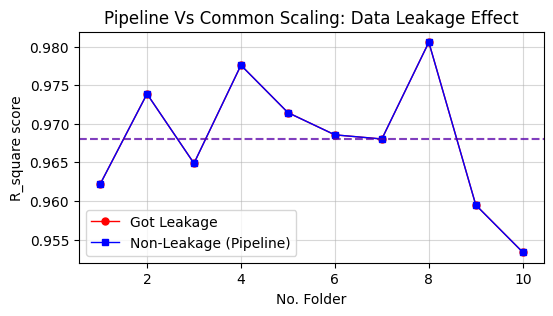

In [12]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Create dataset
np.random.seed(42)
n_samples = 200
X = np.random.randn(n_samples, 2)
# Creat target variable (with some noise)
y = X[:, 0] * 3 + np.random.randn(n_samples) * 0.5

# Common scaling approach -- get data leakage
print("=== Common scaling approach -- get data leakage ===")
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores_leaky = []

for train_idx, test_idx in kf.split(X):
    # scaler the entire dataset before split data, get data leakage
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  
    
    X_train = X_scaled[train_idx]
    X_test = X_scaled[test_idx] # test set get same scaling as train set they have same distribution
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores_leaky.append(score)

print(f"CV Score -- Leakage: {np.mean(scores_leaky):.20f}")
print(f"CV Std -- Leakage: {np.std(scores_leaky):.20f}")

# Pipeline approach -- avoid data leakage
print("\n=== Pipeline approach -- avoid data leakage ===")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

scores_correct = []
for train_idx, test_idx in kf.split(X):
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    scores_correct.append(score)

print(f"CV Score -- Non-Leakage: {np.mean(scores_correct):.20f}")
print(f"CV Std -- Non-Leakage: {np.std(scores_correct):.20f}")

# we can find that literally there is a difference in the CV Score and Std between two approaches when we keep enlarge the decimal places

# Visualization
plt.figure(figsize=(6, 3))
plt.plot(range(1, 11), scores_leaky, 'ro-', label='Got Leakage', linewidth=1, markersize=5)
plt.plot(range(1, 11), scores_correct, 'bs-', label='Non-Leakage (Pipeline)', linewidth=1, markersize=5)
plt.axhline(y=np.mean(scores_leaky), color='r', linestyle='--', alpha=0.5)
plt.axhline(y=np.mean(scores_correct), color='b', linestyle='--', alpha=0.5)
plt.xlabel('No. Folder')
plt.ylabel('R_square score')
plt.title('Pipeline Vs Common Scaling: Data Leakage Effect')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

## Why We Get a Straight Line?

When you obtain a straight line in the plot, it indicates that all five data points (representing the five folds) are perfectly aligned on a horizontal line. This means the R² score for each fold is **exactly identical**. This is an extreme manifestation of **data leakage**:

*   **Deterministic Standardization**: Because the *entire dataset* is used to fit the standardization (e.g., `StandardScaler`) **before** cross-validation splits are made, the standardized data distribution for each fold becomes identical.
*   **Stability of Linear Regression**: For data with strong linear relationships, training a linear regression model on identically distributed (leaked) training data yields **nearly identical model parameters** across all folds.
*   **Consistent Evaluation**: The test data for each fold is also transformed using the **same standardization parameters** (fitted on the full dataset), leading to highly consistent, artificially inflated evaluation results.

# Tutorial for Python Scripts

*[Link](https://blog.csdn.net/wrz427/article/details/157437679?spm=1001.2014.3001.5501)*